# Avoiding or restricting defectors in public goods games?

## By The Anh Han, Luis Moniz Pereira and Tom Lenaerts

Useful references:
- Han, T. A., Pereira, L. M., & Lenaerts, T. (2015). Avoiding or restricting defectors in public goods games?. Journal of the Royal Society Interface, 12(103), 20141203. https://royalsocietypublishing.org/doi/full/10.1098/rsif.2014.1203
- Domingos, E. F., Santos, F. C., & Lenaerts, T. (2023). EGTtools: Evolutionary game dynamics in Python. Iscience, 26(4). https://www.cell.com/iscience/fulltext/S2589-0042(23)00496-0

## Public Good Game with Prior Agreements

In a Public Good Game (PGG), players meet in groups of size $N$. 
They can choose whether to cooperate and contribute an amount, $c$, to the public good or to defect and take advantage of the public good without contributing to it.
The total contribution is multiplied by a factor, $r>1$, and the result is afterwards distributed equally among all players.
With r smaller than the group size ($r<N$), non-contributing free-riders always gain more than contributors.

Prior agreements can address the problem of the evolution of cooperation in the PGG. 
Before the PGG, commitment proposing players ask their co-players to commit to contribute to the PGG, paying a personal proposer’s cost to establish that agreement.
If all the requested co-players accept the commitment, the proposers assume that everyone will contribute to the public good. 
Those individuals who commit, yet later do not contribute, receive a penalty and are forced to compensate the proposers at a cost.

## Objective of the paper

To examine under which conditions avoidance, which is a generalization of the PD commitment behaviour towards the PGG, and restricting strategies are beneficial in the PGG, determining at the same time the conditions when the latter strategy is preferred over the former. 
The effect of the different parameters implicit to the strategies on their viability is carefully analysed. 
Interestingly, we will show that group size is an important factor in determining the conditions for which restriction may be better than simply avoiding non-committers.

## Required Libraries

Beside the usual Numpy and Matplolib, we use EGTTools! See more at https://egttools.readthedocs.io/en/latest/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List

In [3]:
from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex, calculate_nb_states
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_invasion_diagram

## 1. Commitment proposers AVOID interacting with players who refuse the agreement

Table describing the strategies of the game:

| Strategy | Propose Commitment | Accept Commitment | Contribute in PGG |
| --- | --- | --- | --- |
| AVOID | Yes | Yes | Yes |
| C | No | Yes | Yes |
| D | No | No | No |
| FAKE | No | Yes | No |
| FREE | No | Yes | Yes if $N_{AVOID}>0$ |

Conditions:
1. If $N_{AVOID}>0$ AND $N_{D}>0$, the PGG is not played (everyone gets 0)
2. AVOID players share a cost $\epsilon_p$, so each AVOID player pays $\epsilon_p/N_{AVOID}$
3. FAKE players pay a cost $\delta$ to compensate AVOID players, so each AVOID player gains $\delta N_{FAKE}/N_{AVOID}$

In [24]:
class PGGwithCommitment(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int, # number of participants in the PGG
                 c : float, # cost of cooperation
                 r : float, # enhancing factor
                 eps : float, # SHARED cost to propose to commit
                 delta : float, # cost for people who committed but do not contribute
                ):
        AbstractNPlayerGame.__init__(self, 5, group_size)
        self.nb_strategies_ = 5
        self.group_size_ = group_size
        
        #save parameters
        self.strategies = ["AVOID", "C", "FREE", "D", "FAKE"]
        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        
        self.nb_group_configurations_ = self.nb_group_configurations()

        self.calculate_payoffs()
        
    def get_strategy(self,
                     group_composition: Union[List[int], np.ndarray],
                     strategy: str,
                    ):
        
        propose_commit = False # D (but also FAKE)
        accept_commit = False # D
        contribute = False # D (but also FAKE)
        
        if strategy=="AVOID":
            propose_commit = True
            accept_commit = True
            contribute=True
        elif strategy=="C":
            accept_commit = True
            contribute=True
        elif strategy=="FREE":
            accept_commit = True
            if group_composition[0]>0:
                contribute=True
        elif strategy=="FAKE":
            accept_commit = True
        return propose_commit, accept_commit, contribute
        

    def play(self, 
             group_composition: Union[List[int], np.ndarray], 
             game_payoffs: np.ndarray
            ) -> None:
        # iterate over the strategies in the group 
        game_payoffs[:] = 0.
        
        if group_composition[0]==0 or group_composition[-2]==0: # the PGG is played
            #print(group_composition)
            for index, strategy_count in enumerate(group_composition):                
                if strategy_count > 0: # (else: it's not in the group, its payoff is 0)
                    propose_commit, accept_commit, contribute = self.get_strategy(group_composition, self.strategies[index]) 

                    if group_composition[0]>0: # there are players proposing an agreement
                        nb_contributors = np.sum(group_composition[:3])
                        if propose_commit:
                            game_payoffs[index] +=((group_composition[-1]*self.delta - self.eps)/group_composition[0])

                        elif accept_commit and not contribute:   
                            game_payoffs[index] -= self.delta
                    else:
                        nb_contributors = group_composition[1]

                    ratio_contributors = nb_contributors/self.group_size_
                    game_payoffs[index] += (self.c * self.r * ratio_contributors - self.c * contribute)


    def calculate_payoffs(self) -> np.ndarray:
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        for i in range(self.nb_group_configurations_):
            # Get group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype = float)
            #print(group_composition, group_composition[-2])
            self.play(group_composition, payoffs_container)
            
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reinitialize payoff vector
            payoffs_container[:] = 0

        return self.payoffs()
    
    

In [25]:
# Parameters of the Evolutionary Dynamics: They are kept constant throughout the whole paper
Z = 100 # population size
beta = .1 # strength of selection


In [26]:
# Parameters of the game:
group_size = 5

strategy_labels = ["AVOID", "C", "FREE", "D", "FAKE"]
nb_strategies = len(strategy_labels)

c = 1.
r = 3.

eps = 0.25
delta = 2.

In [27]:
game = PGGwithCommitment(group_size, c, r, eps, delta)

[5. 0. 0. 0. 0.] 0.0
[5. 0. 0. 0. 0.]
[4. 1. 0. 0. 0.] 0.0
[4. 1. 0. 0. 0.]
[4. 0. 1. 0. 0.] 0.0
[4. 0. 1. 0. 0.]
[4. 0. 0. 1. 0.] 1.0
[4. 0. 0. 0. 1.] 0.0
[4. 0. 0. 0. 1.]
[3. 2. 0. 0. 0.] 0.0
[3. 2. 0. 0. 0.]
[3. 1. 1. 0. 0.] 0.0
[3. 1. 1. 0. 0.]
[3. 1. 0. 1. 0.] 1.0
[3. 1. 0. 0. 1.] 0.0
[3. 1. 0. 0. 1.]
[3. 0. 2. 0. 0.] 0.0
[3. 0. 2. 0. 0.]
[3. 0. 1. 1. 0.] 1.0
[3. 0. 1. 0. 1.] 0.0
[3. 0. 1. 0. 1.]
[3. 0. 0. 2. 0.] 2.0
[3. 0. 0. 1. 1.] 1.0
[3. 0. 0. 0. 2.] 0.0
[3. 0. 0. 0. 2.]
[2. 3. 0. 0. 0.] 0.0
[2. 3. 0. 0. 0.]
[2. 2. 1. 0. 0.] 0.0
[2. 2. 1. 0. 0.]
[2. 2. 0. 1. 0.] 1.0
[2. 2. 0. 0. 1.] 0.0
[2. 2. 0. 0. 1.]
[2. 1. 2. 0. 0.] 0.0
[2. 1. 2. 0. 0.]
[2. 1. 1. 1. 0.] 1.0
[2. 1. 1. 0. 1.] 0.0
[2. 1. 1. 0. 1.]
[2. 1. 0. 2. 0.] 2.0
[2. 1. 0. 1. 1.] 1.0
[2. 1. 0. 0. 2.] 0.0
[2. 1. 0. 0. 2.]
[2. 0. 3. 0. 0.] 0.0
[2. 0. 3. 0. 0.]
[2. 0. 2. 1. 0.] 1.0
[2. 0. 2. 0. 1.] 0.0
[2. 0. 2. 0. 1.]
[2. 0. 1. 2. 0.] 2.0
[2. 0. 1. 1. 1.] 1.0
[2. 0. 1. 0. 2.] 0.0
[2. 0. 1. 0. 2.]
[2. 0. 0. 3. 0.] 3.0
[2. 0

In [7]:
# # Payoffs:

# nb_group_configurations = calculate_nb_states(group_size, nb_strategies)

# payoffs = game.payoffs()


# for j in range(nb_group_configurations):
#     group_configuration = sample_simplex(index=j, pop_size=group_size, nb_strategies=nb_strategies)
#     if group_configuration[:2].sum()>0 and (group_configuration>0).sum()<2.5: 
#         print("payoffs of strategies "+str(strategy_labels)+" in group configuration "+str(group_configuration))
#         print(np.round(payoffs[:,j], 3),'\n')

In [8]:
evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

sd_avoid = stationary_distribution[0]

### Figure 1A - Stationary distribution and fixation probabilities

The population spends most of the time in the homogeneous state of AVOID. 
The black arrows identify the advantageous transitions, where $\rho_N=1/Z$ denotes the neutral fixation probability. 
The dashed lines denote neutral transitions. 
Note the cyclic pattern from cooperation to defection to commitment strategies and back.

Note: in the following plot, an arrow from A to B means A is invaded by B

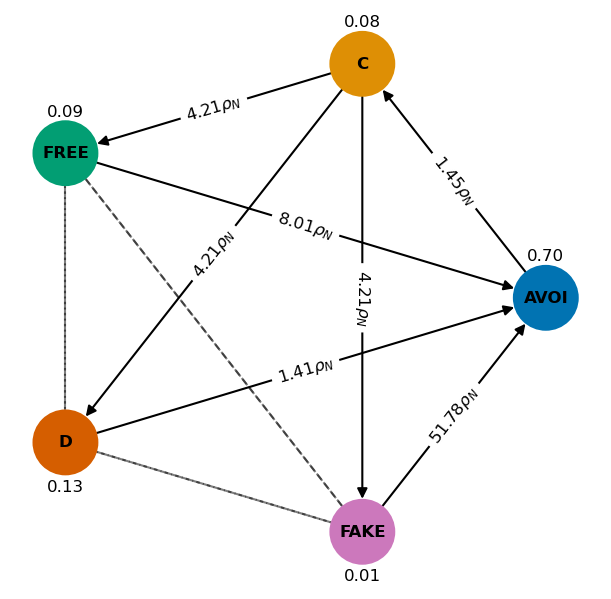

In [9]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.show() # display

In [10]:
nb_points = 5
eps_values = np.linspace(0., 2., nb_points)
delta_values = np.linspace(0., 6., nb_points)

avoid_frequency = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, delta in enumerate(delta_values):
        game = PGGwithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        avoid_frequency[i,j] = stationary_distribution[0]
        

### Figure 1B - Contour plot of the frequency of AVOID as a function of $\epsilon_p$ and $\delta$

For a small enough cost of arranging the commitment, AVOID is abundant whenever a sufficient compensation is associated with the commitment deal.

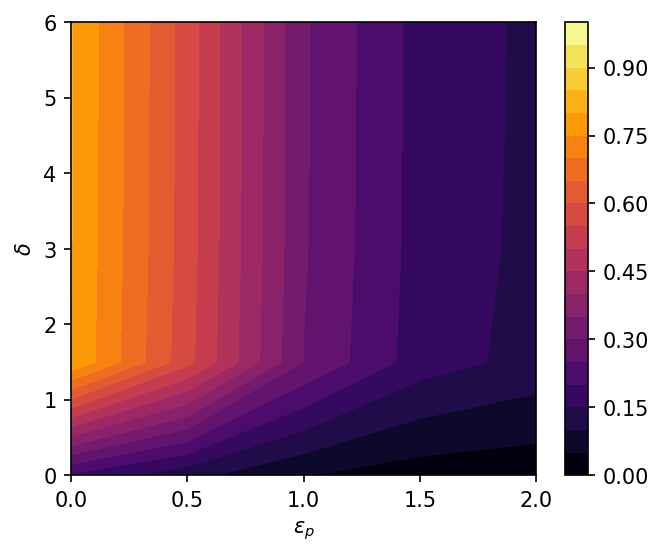

In [11]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 1., 21)

fig, ax = plt.subplots(figsize= (5,4), dpi=150)
tmp = ax.contourf(eps_values, delta_values, avoid_frequency.T, levels=levels, cmap='inferno', vmin = 0., vmax = 1.,)
ax.set_xlabel(r'$\epsilon_p$')
ax.set_ylabel(r'$\delta$')
fig.colorbar(tmp,orientation='vertical',)

plt.show()

## 2. Commitment proposers RESTRICT the access of non-committers to the public good

Table describing the strategies of the game:

| Strategy | Propose Commitment | Accept Commitment | Contribute in PGG |
| --- | --- | --- | --- |
| RESTRICT | Yes | Yes | Yes |
| C | No | Yes | Yes |
| D | No | No | No |
| FAKE | No | Yes | No |
| FREE | No | Yes | Yes if $N_{RESTRICT}>0$ |

Conditions:
1. The PGG is ALWAYS played
2. RESTRICT players share a cost $\epsilon_p$, so each RESTRICT player pays $\epsilon_p/N_{RESTRICT}$
3. if $N_D>0$, RESTRICT players share a cost $\epsilon_r$, so each RESTRICT player pays $\epsilon_r/N_{RESTRICT}$
4. FAKE players pay a cost $\delta$ to compensate RESTRICT players, so each RESTRICT player gains $\delta N_{FAKE}/N_{RESTRICT}$
5. RESTRICT players impose a restriction to D players modelled through a factor $\psi<1$ representing the fraction of the common resource they receive compared to the committed players

In [12]:
class PGGwithCommitmentRESTRICT(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,
                 c : float, # cost of cooperation
                 r : float, # enhancing factor
                 eps_p : float, # SHARED cost to propose to commit
                 delta : float, # cost for people who committed but do not contribute
                 eps_r: float, # cost to restrict the access of the non-committers to the public good
                 psi: float, # fraction of the common resource the non-committers receive compared to the committed players
                ):
        AbstractNPlayerGame.__init__(self, 5, group_size)
        self.nb_strategies_ = 5
        self.group_size_ = group_size
        
        
        #save parameters
        self.strategies = ["RESTRICT", "C", "FREE", "D", "FAKE"]
        self.c = c
        self.r = r
        self.eps_p = eps_p
        self.delta = delta
        self.eps_r = eps_r
        self.psi = psi
        
        self.nb_group_configurations_ = self.nb_group_configurations()
        #print(self.nb_group_configurations_)

        self.calculate_payoffs()
        
    def get_strategy(self,
                     group_composition: Union[List[int], np.ndarray],
                     strategy: str,
                    ):
        
        propose_commit = False # D (but also FAKE)
        accept_commit = False # D
        contribute = False # D (but also FAKE)
        
        if strategy=="RESTRICT":
            propose_commit = True
            accept_commit = True
            contribute=True
        elif strategy=="C":
            accept_commit = True
            contribute=True
        elif strategy=="FREE":
            accept_commit = True
            if group_composition[0]>0:
                contribute=True
        elif strategy=="FAKE":
            accept_commit = True
        return propose_commit, accept_commit, contribute
        

    def play(self, 
             group_composition: Union[List[int], np.ndarray], 
             game_payoffs: np.ndarray
            ) -> None:
        # iterate over the strategies in the group
        game_payoffs[:] = 0.
        
        for index, strategy_count in enumerate(group_composition):
            if strategy_count > 0: # (else: it's not in the group, its payoff is 0)
                propose_commit, accept_commit, contribute=self.get_strategy(group_composition, self.strategies[index]) 

                if group_composition[0]>0: # there are players proposing an agreement
                    nb_contributors = np.sum(group_composition[:3])

                    if propose_commit:
                        game_payoffs[index]+=((group_composition[-1]*self.delta - self.eps_p)/group_composition[0])

                        if group_composition[-2]>0: # there are Defectors
                            game_payoffs[index] -= (self.eps_r/group_composition[0])
                            group_composition[-2] *= self.psi

                    elif accept_commit and not contribute:   
                        game_payoffs[index] -= self.delta

                else:
                    nb_contributors = group_composition[1]

                ratio_contributors = nb_contributors/np.sum(group_composition)

                if accept_commit:
                    game_payoffs[index] += (self.c * self.r * ratio_contributors - self.c * contribute)
                else:
                    game_payoffs[index] += (self.c * self.r * ratio_contributors * (1 - (1 - self.psi)*(group_composition[0]>0)))
                   

                    
    def calculate_payoffs(self) -> np.ndarray:
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        for i in range(self.nb_group_configurations_):
            # Get group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype = float)
            self.play(group_composition, payoffs_container)
            
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reinitialize payoff vector
            payoffs_container[:] = 0

        return self.payoffs()
    
    

In [13]:
# Parameters of the game:

group_size = 5
strategy_labels = ["RESTRICT", "C", "FREE", "D", "FAKE"]
nb_strategies = len(strategy_labels)

c = 1.
r = 3.

eps_p = 0.25
delta = 2.

eps_r = 0.5
psi = 0.25

game = PGGwithCommitmentRESTRICT(group_size, c, r, eps_p, delta, eps_r, psi)

# # Payoffs:

# nb_group_configurations = calculate_nb_states(group_size, nb_strategies)

# for i, strategy in enumerate(strategy_labels):
#     for j in range(nb_group_configurations):
#         group_configuration = sample_simplex(index=j, pop_size=group_size, nb_strategies=nb_strategies)
#         payoffs = game.payoffs()
#         print("payoff of strategy "+str(strategy)+" in group configuration "+str(group_configuration))
#         print(np.round(payoffs[i,j], 3))

evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

### Figure 2A - Stationary distribution and fixation probabilities

The population spends most of the time in the homogeneous state of RESTRICT. 
The black arrows identify the advantageous transitions, where $\rho_N=1/Z$ denotes the neutral fixation probability. 
The dashed lines denote neutral transitions. 
Note the cyclic pattern from cooperation to defection to commitment strategies and back.

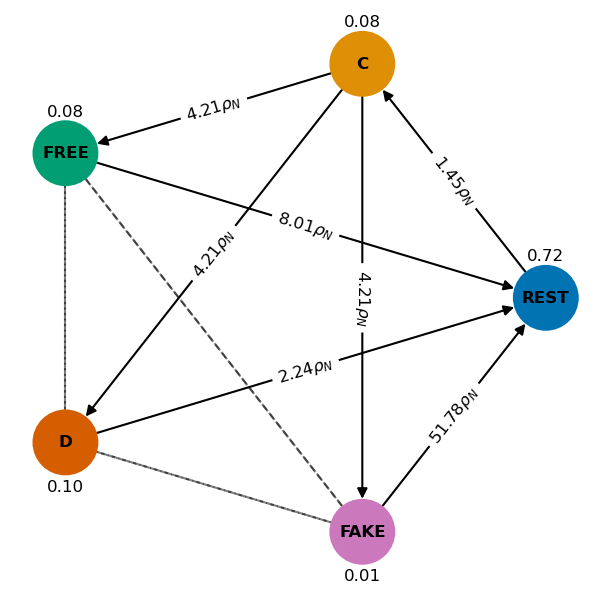

In [14]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.show() # display

In [15]:
nb_points = 10
psi_values = np.linspace(0., 1., nb_points)

frequency = np.zeros((nb_points, nb_strategies), dtype = float)

for i, psi in enumerate(psi_values):

    game = PGGwithCommitmentRESTRICT(group_size, c, r, eps_p, delta, eps_r, psi)
    evolver = PairwiseComparison(Z, game)
    transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

    frequency[i,:] = stationary_distribution

### Figure 2B - Frequencies of each strategy for varying $\psi$

For a given cost of restriction ($\epsilon_r = 0.5$), in general the better the effect of restriction on non-committers (i.e. the smaller $\psi$), the greater the frequency of RESTRICT.

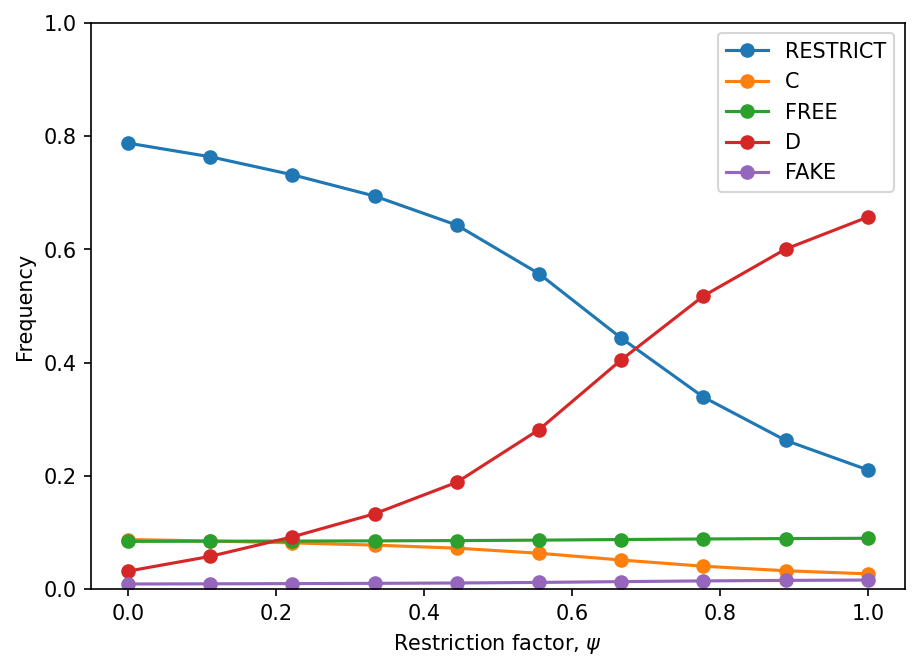

In [16]:
fig, ax = plt.subplots(figsize=(7,5), dpi=150)
ax.plot(psi_values, frequency, marker='o')
ax.legend(strategy_labels)
ax.set_ylim(0., 1.)
ax.set_xlabel(r'Restriction factor, $\psi$')
ax.set_ylabel('Frequency')
plt.show()

In [17]:
group_size = 5

strategy_labels = ["RESTRICT", "C", "FREE", "D", "FAKE"]
nb_strategies = len(strategy_labels)

c = 1.
r = 3.

eps_p = 0.25
delta = 2.

In [18]:
nb_points = 5
eps_r_values = np.linspace(0., 1., nb_points)
psi_values = np.linspace(0., 1., nb_points)

restrict_frequency = np.zeros((nb_points, nb_points), dtype = float)

for i, eps_r in enumerate(eps_r_values):
    for j, psi in enumerate(psi_values):
        game = PGGwithCommitmentRESTRICT(group_size, c, r, eps_p, delta, eps_r, psi)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        restrict_frequency[i,j] = stationary_distribution[0]

### Figure 2C - Contour plot of the frequency of RESTRICT as a function of $\epsilon_r$ and $\psi$

Frequency of RESTRICT as a function of $\epsilon_r$ and $c$, in a population with C, D, FREE and FAKE strategies.
For a large range of cost for restricting the access of non-committers, $\epsilon_r$, and the restriction, $c$, RESTRICT is highly frequent, having a higher frequency than AVOID. 
In general, the larger $\epsilon_r$, the smaller $c$ is required for RESTRICT to be advantageous to AVOID.

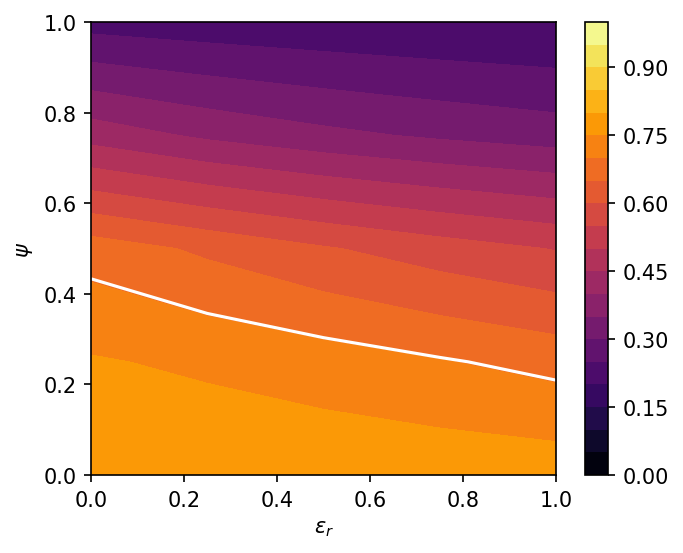

In [19]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 1., 21)

fig, ax = plt.subplots(figsize= (5,4), dpi=150)
tmp = ax.contourf(eps_r_values, psi_values, restrict_frequency.T, levels=levels, cmap='inferno', vmin = 0., vmax = 1.,)
tmp2 = ax.contour(eps_r_values, psi_values, restrict_frequency.T, levels=[sd_avoid], colors='white')
ax.set_xlabel(r'$\epsilon_r$')
ax.set_ylabel(r'$\psi$')
fig.colorbar(tmp, orientation='vertical')

plt.show()

In [20]:
eps_r = 2.
psi=0.25
group_size_values = np.arange(5, 26, 5)
nb_points = len(group_size_values)

frequency = np.zeros((nb_points, nb_strategies), dtype = float)

for i, group_size in enumerate(group_size_values):

    game = PGGwithCommitmentRESTRICT(group_size=group_size, c=1., r=3., eps_p=0.25, delta=2., eps_r=2., psi=0.25)
    evolver = PairwiseComparison(Z, game)
    transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

    frequency[i,:] = stationary_distribution

### Figure 2D - Frequencies of each strategy as a function of the group size, $N$

We did not manage to reproduce this figure!

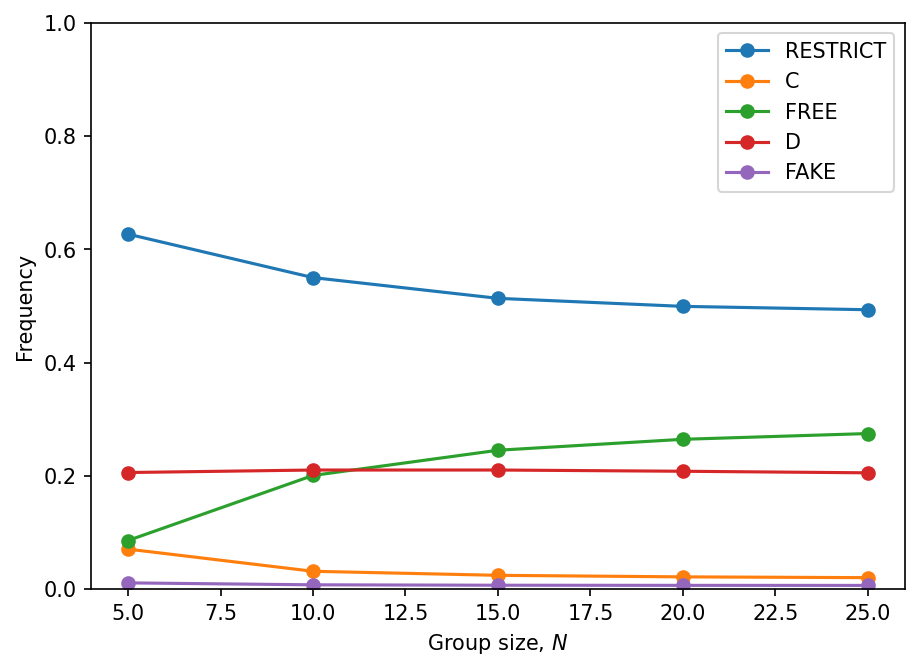

In [21]:
fig, ax = plt.subplots(figsize=(7,5), dpi=150)
ax.plot(group_size_values, frequency, marker='o')
ax.legend(strategy_labels)
ax.set_ylim(0., 1.)
ax.set_xlabel(r'Group size, $N$')
ax.set_ylabel('Frequency')
plt.show()

## Supplementary material

### Figure S1

In [22]:
nb_points = 10
eps_p_values = np.linspace(0., 2., nb_points)

frequency = np.zeros((nb_points, nb_strategies), dtype = float)

for i, eps_p in enumerate(eps_p_values):

    game = PGGwithCommitment(group_size=5, c=1, r=3, eps=eps_p, delta=2,)
    evolver = PairwiseComparison(100, game)
    transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta=0.1)
    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

    frequency[i,:] = stationary_distribution

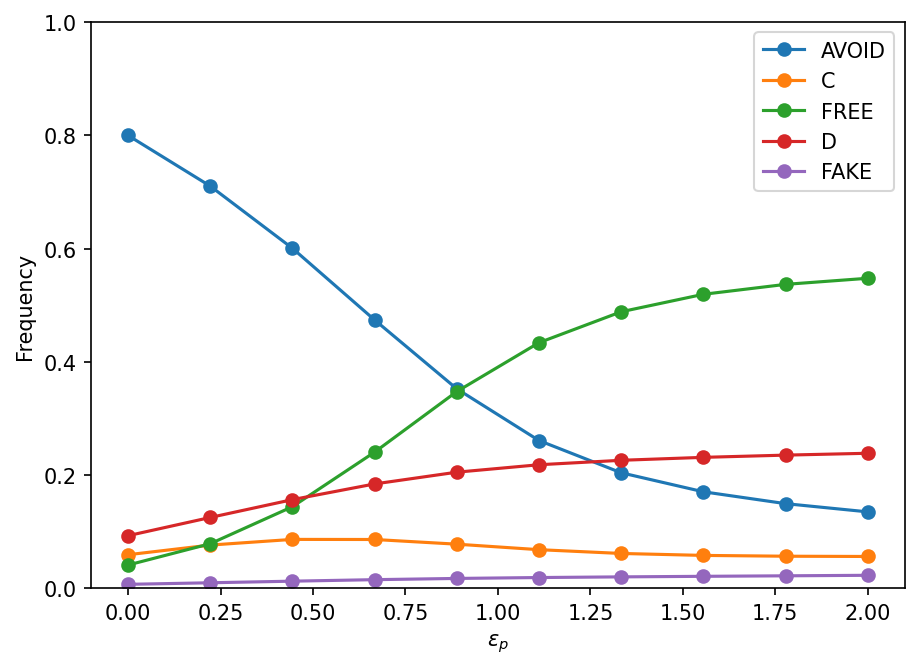

In [23]:
fig, ax = plt.subplots(figsize=(7,5), dpi=150)
ax.plot(eps_p_values, frequency, marker='o')
ax.legend(["AVOID"]+strategy_labels[1:])
ax.set_ylim(0., 1.)
ax.set_xlabel(r'$\epsilon_p$')
ax.set_ylabel('Frequency')
plt.show()

In [24]:
frequency = np.zeros((nb_points, nb_strategies), dtype = float)

for i, eps_p in enumerate(eps_p_values):

    game = PGGwithCommitmentRESTRICT(group_size=5, c=1, r=3, eps_p=eps_p, delta=2, eps_r=1., psi=0.5)
    evolver = PairwiseComparison(100, game)
    transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta=0.1)
    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

    frequency[i,:] = stationary_distribution

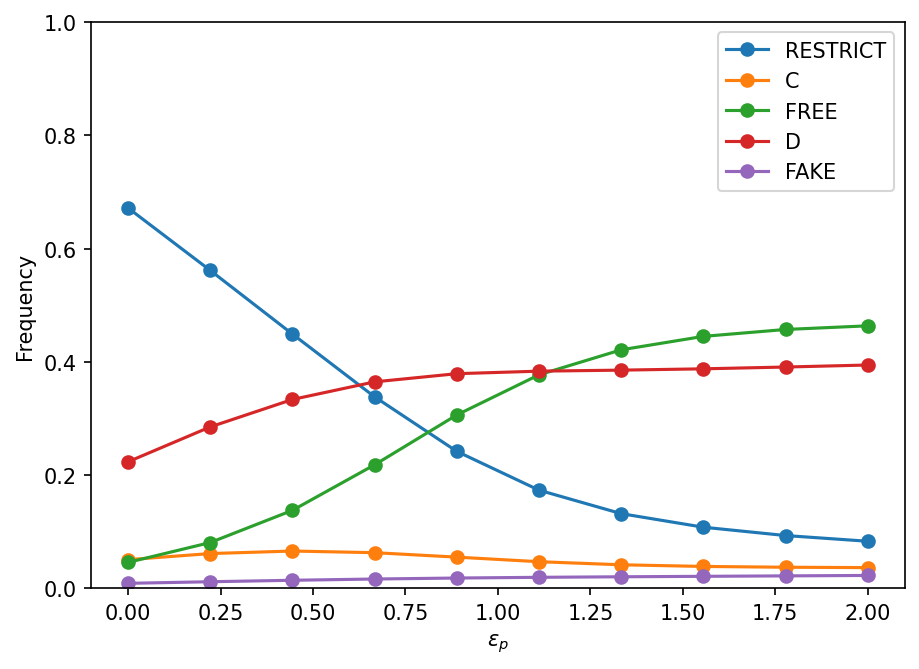

In [25]:
fig, ax = plt.subplots(figsize=(7,5), dpi=150)
ax.plot(eps_p_values, frequency, marker='o')
ax.legend(["RESTRICT"]+strategy_labels[1:])
ax.set_ylim(0., 1.)
ax.set_xlabel(r'$\epsilon_p$')
ax.set_ylabel('Frequency')
plt.show()

##### 

### Figure S2

In [26]:
game = PGGwithCommitmentRESTRICT(group_size=5, c=1, r=3, eps_p=0.25, delta=2, eps_r=0.5, psi=0.25)
evolver = PairwiseComparison(100, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(0.1)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

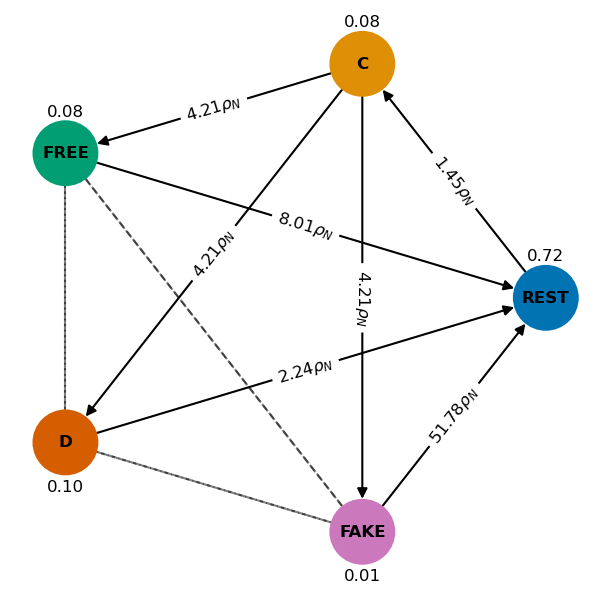

In [27]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.show() # display

In [28]:
game = PGGwithCommitmentRESTRICT(group_size=5, c=1, r=3, eps_p=0.25, delta=2, eps_r=0.5, psi=0.5)
evolver = PairwiseComparison(100, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(0.1)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

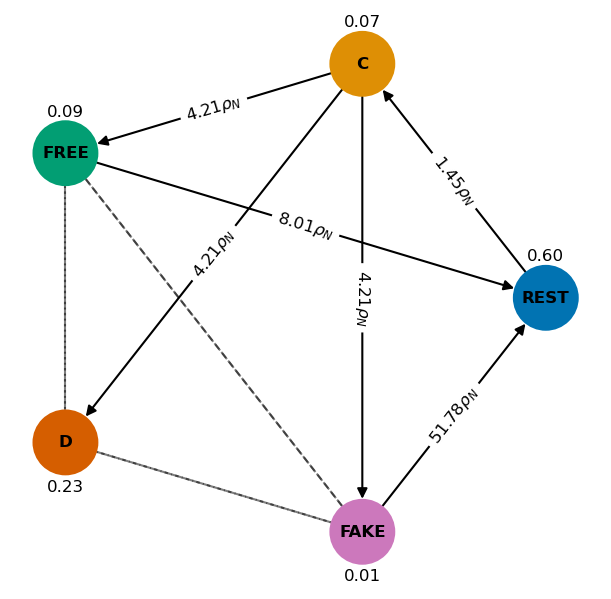

In [29]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.show() # display